In [70]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
zonas_protegidas_canarias = gpd.read_file("../data/eennpp.shp")

<Axes: >

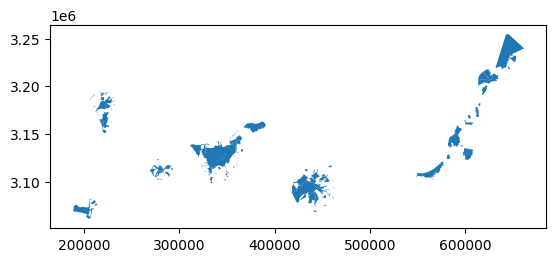

In [3]:
zonas_protegidas_canarias.plot()

In [4]:
zonas_protegidas_canarias.describe()

,codigo,categoria,nombre,geometry
count,146,146,146,146
unique,146,8,145,146
top,H-6,Monumento Natural,El Teide,"POLYGON ((207380.29950546904 3077264.52436294,..."
freq,1,52,2,1


In [87]:
# zonas_protegidas_canarias["codigo_nombre"] = zonas_protegidas_canarias["codigo"] + " " + zonas_protegidas_canarias["nombre"]
np.array(zonas_protegidas_canarias["codigo"])

array(['H-6', 'H-7', 'H-3', 'H-2', 'H-5', 'H-4', 'H-1', 'F-13', 'F-2',
       'F-5', 'F-6', 'F-10', 'F-7', 'F-9', 'F-4', 'F-3', 'F-12', 'F-1',
       'F-11', 'F-8', 'C-32', 'C-31', 'C-30', 'C-29', 'C-28', 'C-27',
       'C-26', 'C-25', 'C-24', 'C-23', 'C-22', 'C-19', 'C-18', 'C-17',
       'C-16', 'C-15', 'C-14', 'C-12', 'C-10', 'C-09', 'C-08', 'C-07',
       'C-06', 'C-05', 'C-20', 'C-04', 'C-03', 'C-02', 'C-33', 'C-11',
       'C-21', 'C-01', 'G-1', 'G-11', 'G-12', 'G-16', 'G-2', 'G-3', 'G-6',
       'G-9', 'G-7', 'G-13', 'G-8', 'G-15', 'G-10', 'G-14', 'G-4', 'G-5',
       'P-11', 'P-19', 'P-7', 'P-13', 'P-1', 'P-18', 'P-9', 'P-14',
       'P-17', 'P-16', 'P-5', 'P-4', 'P-15', 'P-10', 'P-2', 'P-6', 'P-8',
       'P-3', 'P-12', 'L-11', 'L-12', 'L-03', 'L-04', 'L-07', 'L-08',
       'L-05', 'L-09', 'L-10', 'L-02', 'L-01', 'T-20', 'T-27', 'T-26',
       'T-21', 'T-38', 'T-37', 'T-31', 'T-13', 'T-14', 'T-25', 'T-30',
       'T-15', 'T-39', 'T-32', 'T-19', 'T-40', 'T-8', 'T-23', 'T-17',
 

KeyError: 'nombre_lugar'

In [27]:
prueba = np.repeat(np.arange(1, (len(zonas_protegidas_canarias)//3) + 1), 3)[:len(zonas_protegidas_canarias)]

In [31]:
# zonas_protegidas_canarias["colors"] = 

np.add([49, 49])

array([ 1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
       18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23,
       23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29,
       29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34,
       35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40,
       40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46,
       46, 46, 47, 47, 47, 48, 48, 48])

In [36]:
repeat_colors = np.append(prueba, [49,49])

In [37]:
zonas_protegidas_canarias["colors"] = repeat_colors

<Axes: >

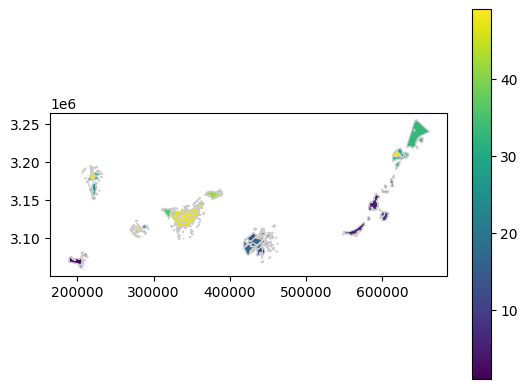

In [43]:
zonas_protegidas_canarias.plot(column='colors', cmap='viridis', linewidth=0.8, edgecolor='0.8', legend=True)

In [110]:
grancanaria_gdf = zonas_protegidas_canarias[zonas_protegidas_canarias['codigo'].str.startswith(('G', 'C'))]

In [111]:
grancanaria_gdf = zonas_protegidas_canarias[grancanaria]

In [112]:
print(pd.DataFrame(grancanaria_gdf))

    codigo                    categoria                   nombre  \
20    C-32  Sitio de Interés Científico       Juncalillo del Sur   
21    C-31  Sitio de Interés Científico           Roque de Gando   
22    C-30  Sitio de Interés Científico                    Tufia   
23    C-29  Sitio de Interés Científico                  Jinámar   
24    C-28            Paisaje Protegido       Montaña de Agüimes   
25    C-27            Paisaje Protegido                   Fataga   
26    C-26            Paisaje Protegido             Lomo Magullo   
27    C-25            Paisaje Protegido              Las Cumbres   
28    C-24            Paisaje Protegido                   Tafira   
29    C-23            Paisaje Protegido               Pino Santo   
30    C-22            Paisaje Protegido                La Isleta   
31    C-19            Monumento Natural   Barranco de Guayadeque   
32    C-18            Monumento Natural                  Arinaga   
33    C-17            Monumento Natural         

C:\Users\jcge9\AppData\Local\Temp\ipykernel_9808\1881975623.py:6: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  grancanaria_gdf_filtered.plot()


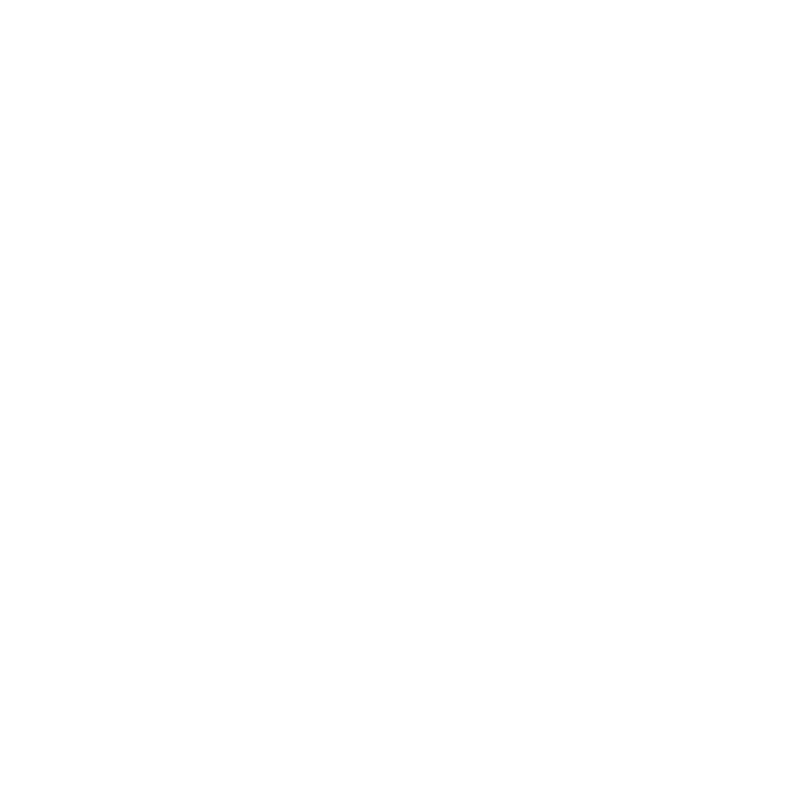

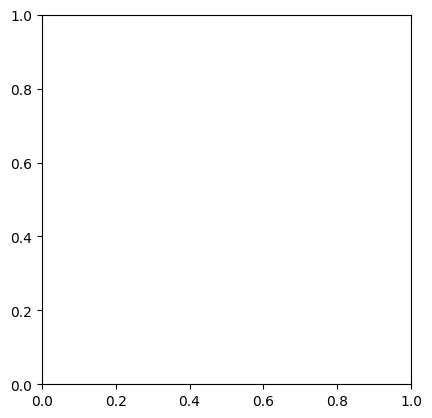

In [127]:
grancanaria_gdf_filtered = grancanaria_gdf[grancanaria_gdf['geometry'].geom_type == 'Point']
grancanaria_gdf_filtered = grancanaria_gdf_filtered[grancanaria_gdf_filtered['geometry'].x > 400000]

# Plot the filtered GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
grancanaria_gdf_filtered.plot()
ax.set_axis_off()


In [132]:
grancanaria_gdf_filtered[grancanaria_gdf_filtered['geometry']]

""
